In [1]:
# Fuentes y recursos:
# http://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/
# https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
# http://blog.yhat.com/posts/python-random-forest.html
# https://chrisalbon.com/machine-learning/random_forest_classifier_example_scikit.html
# Datos: https://drive.google.com/open?id=0B-dmEvN59Z2ZcnZmY2d5ekRESlk

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

belisario = pd.read_csv("regressionData.csv")  # Leer archivo de datos
# Creamos una columna adicional con la clase
belisario['PL2'] = np.where(belisario['PARTICULAS.microg.m3.']>=15, 'UH', 'H')
print(belisario.head())  # visualizamos los datos
# Y mostramos un resumen estadístico
print('\nSummary:\n', belisario.describe())  # Variables numéricas
print('\nSummary PL2:\n', belisario.PL2.describe())  # Var Categórica

   PRECIPITATION.mm.         X         Y  PARTICULAS.microg.m3. PL2
0                9.3 -1.097987  1.562858                  24.84  UH
1                0.1 -2.602452 -0.948759                  17.81  UH
2                0.0 -3.238200  0.107988                  15.86  UH
3                0.0  1.807980  1.812404                  26.33  UH
4                0.0  1.482232  1.473462                  23.46  UH

Summary:
        PRECIPITATION.mm.            X            Y  PARTICULAS.microg.m3.
count        1587.000000  1587.000000  1587.000000            1587.000000
mean            3.111483    -0.508142     0.981576              18.421028
std             6.195972     1.397499     0.879884               5.458568
min             0.000000    -6.233477    -4.155201               5.740000
25%             0.000000    -1.372969     0.568808              14.865000
50%             0.100000    -0.609217     1.164141              18.360000
75%             3.111483     0.611006     1.554612             

/home/salva/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


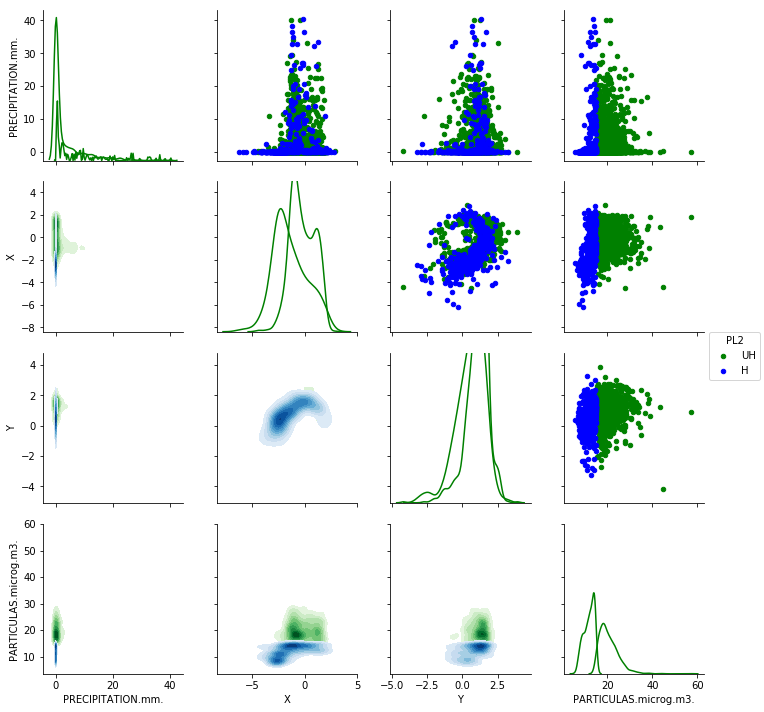

In [2]:
# Visualizamos los datos con seaborn

def infer_cmap(color):
    if color == (0., 0., 1.):
        return 'Blues'
    elif color == (0., 0.5, 0.):
        return 'Greens'
    elif color == (1., 0., 0.):
        return 'Reds'


def kde_hue(x, y, **kws):
    # ax = plt.gca()
    cmap = infer_cmap(kws['color'])
    return sns.kdeplot(data=x, data2=y, shade=True, shade_lowest=False, cmap=cmap, **kws)
    #return ax


colores = ['b', 'g']
var = 'PL2'

color_dict = {}
for idx, v in enumerate(np.unique(belisario[var])):
    color_dict[v] = colores[idx]
    
g = sns.PairGrid(belisario, hue=var, palette=color_dict)
g = g.map_lower(kde_hue)
g = g.map_upper(plt.scatter, s=20)
g = g.map_diag(sns.kdeplot)
g = g.add_legend()
plt.show()

In [3]:
# Vamos a implementar un modelo de aprendizaje automático
# para clasificar los datos en saludable y no saludable 
# a partir de los resultados de un análisis de regresión.

# Importamos de la librería sklearn la función 
# train_test_split para construir nuestros conjuntos
# de entrenamiento y prueba

from sklearn.model_selection import train_test_split

# Separamos nuestros datos en atributos
X = belisario[belisario.columns[0:3]]

# Y clase (valor continuo PM2.5)
y = belisario[belisario.columns[3]]

# random_state: semilla del generador de números aleatorios
# test_size: los datos se han separado en
#   entrenamiento: 80%
#   test: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

# Comprobamos la separación anterior
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1269, 3) (1269,)
(318, 3) (318,)


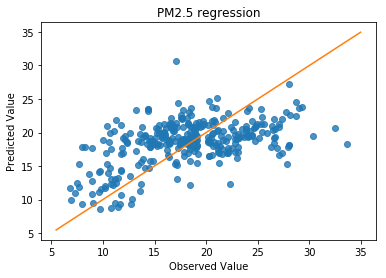

Feature's importance


X                    0.543369
Y                    0.324796
PRECIPITATION.mm.    0.131836
dtype: float64

In [4]:
# Importamos el Regresor basado en
# Random forest que es un método de aprendizaje
# conjunto (ensemble learning)

from sklearn.ensemble import RandomForestRegressor

def abline():
    gca = plt.gca()
    gca.plot((gca.get_xlim()),gca.get_xlim())
    

# rf almacena el objeto regresor 
# random_state: semilla
# n_estimators: número de estimadores base (árboles)
rf = RandomForestRegressor(n_estimators=100, random_state=123456)

# Entrenamos el regresor rf, con el conjunto de entramiento
# regresor(X, y)
rf.fit(X_train, y_train)

# Vamos a usar el conjunto de prueba para obtener
# predicciones a partir de X_test
predicted = rf.predict(X_test)

# Graficamos los valores observados (reales) vs. estimados
ax = sns.regplot(y_test, predicted, fit_reg=False)
ax.set(xlabel='Observed Value', ylabel='Predicted Value', title="PM2.5 regression")

# Una línea guía para tener idea de la calidad de la regresión
abline()
plt.show()

# Importancia de las variables
print("Feature's importance")
feature_imp = pd.Series(rf.feature_importances_,index=list(X)).sort_values(ascending=False)
feature_imp

In [5]:
# Imprimimos algunas métricas relacionadas a nuestra regresión
# Ver: http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

print("MAE:", mean_absolute_error(y_test, predicted))
print("MSE:", mean_squared_error(y_test, predicted))
print("Explained Variance:", explained_variance_score(y_test, predicted))
print("R2:", r2_score(y_test, predicted))

MAE: 3.7406850621816217
MSE: 21.303460552353886
Explained Variance: 0.24543412953923627
R2: 0.24036918352033465


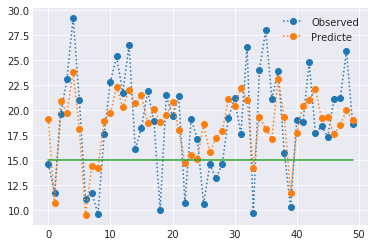

In [6]:
# A partir de la regresión haremos un análisis 
# de clasificación en a partir del valor continuo estimado
# Healthy < 15
# UnHealth > 15

# Veamos gráficamente lo que queremos lograr
# La línea roja es el valor que separa las clases
# Si los puntos correspondientes están ambos por
# debajo o arriba de la línea roja, la clasificación
# es correcta

sns.set_style("darkgrid")
plt.plot(np.array(y_test)[0:50], ':o', label="Observed")
plt.plot(predicted[0:50], ':o', label="Predicte")
plt.plot(np.ones(50)*15)  # línea de referencia para las clases
plt.legend()
plt.show()

In [7]:
# Vamos a evaluar la clasificación de nuestro modelo
# Haremos las transformaciones correspondientes
# Binarizamos el resultado en base a nuestro valor de 
# separación de clases PM2.5=15 

classified_data = pd.DataFrame()
classified_data['observed'] = np.where(y_test>=15, 'UH', 'H')
classified_data['predicted'] = np.where(predicted>=15, 'UH', 'H')
classified_data['observed_bin'] = np.where(y_test>=15, 1, 0)
classified_data['predicted_bin'] = np.where(predicted>=15, 1, 0)
print(classified_data.head())
print("\nSummary\n", classified_data[['observed', 'predicted']].describe())

  observed predicted  observed_bin  predicted_bin
0        H        UH             0              1
1        H         H             0              0
2       UH        UH             1              1
3       UH        UH             1              1
4       UH        UH             1              1

Summary
        observed predicted
count       318       318
unique        2         2
top          UH        UH
freq        231       276


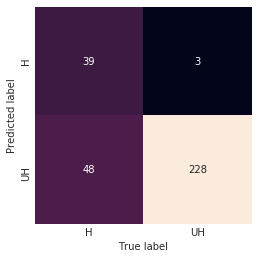

             precision    recall  f1-score   support

          0       0.93      0.45      0.60        87
          1       0.83      0.99      0.90       231

avg / total       0.85      0.84      0.82       318



In [8]:
# Podemos visualizar la calidad de un clasificador
# usando una matriz de confusión
# Además de las métricas de clasificación

from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(confusion_matrix(classified_data['observed'],
                                   classified_data['predicted']),
                  columns=classified_data['observed'].unique(),
                  index=classified_data['observed'].unique())

sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

print(classification_report(classified_data['observed_bin'], 
                              classified_data['predicted_bin']))

In [9]:
#Import scikit-learn dataset library
from sklearn import datasets

#Load dataset
iris = datasets.load_iris()

# print the label species(setosa, versicolor,virginica)
print(iris.target_names)

# print the names of the four features
print(iris.feature_names)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


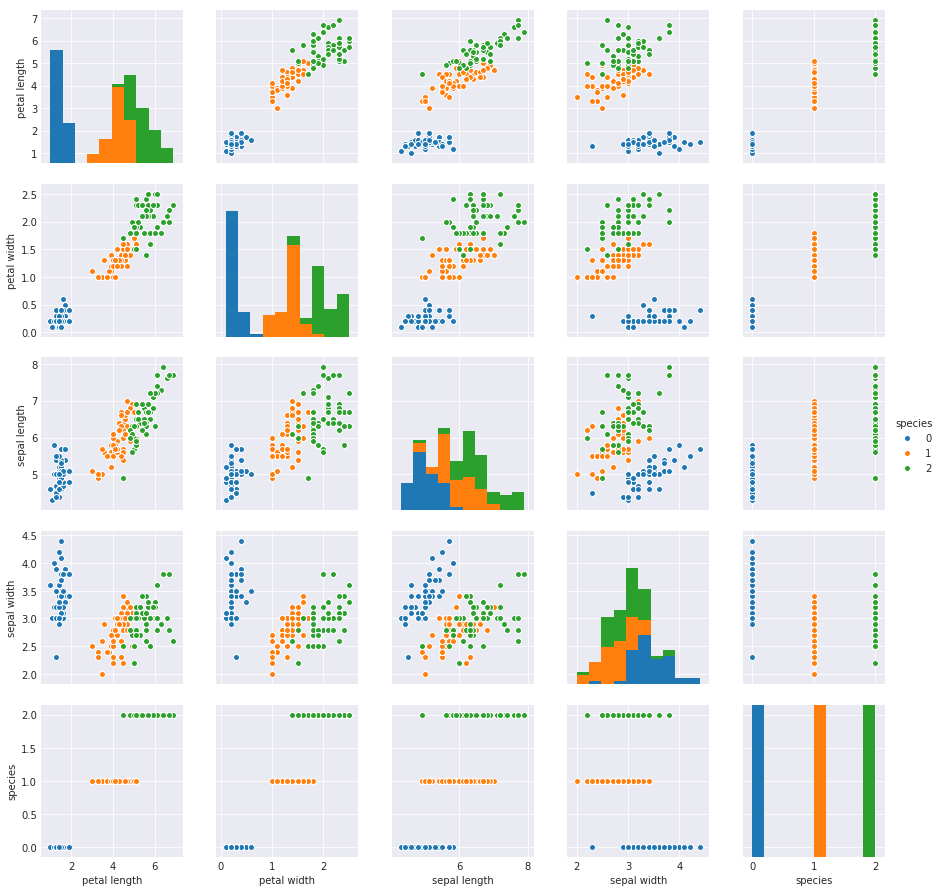

In [10]:
import pandas as pd
data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
data.head()

sns.pairplot(data, hue="species")
plt.show()

In [11]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=data['species']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [12]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [13]:
confusion_matrix(y_test, y_pred)

array([[15,  0,  0],
       [ 0, 14,  0],
       [ 0,  0, 16]])

In [14]:
feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
feature_imp

petal length (cm)    0.434950
petal width (cm)     0.415854
sepal length (cm)    0.108115
sepal width (cm)     0.041081
dtype: float64